In [1]:
import inspect
import os
from pathlib import Path
import DifferentiableStateSpaceModels
from DifferentiableStateSpaceModels import *
from sympy import *
from copy import deepcopy
import numpy as np

init_printing()  # for nice sympy expressions in jupyter

In [2]:
# Define the symbols
α, β, ρ, δ, σ, Ω_1 = symbols('α β ρ δ σ Ω_1')  # parameters
t = symbols('t', integer=True)  # time index (integer)
k, z, c, q = symbols('k z c q', cls=Function)  # undefined functions

# Define the states, controls, and parameters
x = [k, z]  # states - list of functions
y = [c, q]  # controls - list of functions
p = [α, β, ρ, δ, σ, Ω_1]  # parameters - list of symbols

# Define the system of model equations - list of expressions
H = [
    1 / c(t) - (β / c(t + 1)) *
    (α * exp(z(t + 1)) * k(t + 1)**(α - 1) + (1 - δ)),
    c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
    q(t) - exp(z(t)) * k(t)**α,
    z(t + 1) - ρ * z(t)
]

# Define the steady states - list of equations
steady_states = [
    Eq(k(oo), (((1 / β) - 1 + δ) / α)**(1 / (α - 1))),
    Eq(z(oo), 0),
    Eq(c(oo), (((1 / β) - 1 + δ) / α)**(α / (α - 1)) -
       δ * (((1 / β) - 1 + δ) / α)**(1 / (α - 1))),
    Eq(q(oo), (((1 / β) - 1 + δ) / α)**(α / (α - 1)))
]

# Define the matrix for the 1 shock
Γ = Matrix([σ])  # DenseMatrix

# Define the n_x * n_ϵ matrix
η = Matrix([0, -1])  # DenseMatrix

# Define the observation matrix
Q = Matrix([[1.0, 0, 0, 0], [0, 0, 1.0, 0]])  # DenseMatrix

# Define the diagonal cholesky of covariance matrix for observation noise
Ω = [Ω_1, Ω_1]  # list of symbols

# Generates the files and includes if required.  If the model is already created, then just loads
overwrite_model_cache = True

In [3]:
def default_model_cache_location():
    """
    Returns the default location for the model cache
    :return: path of a folder joining the package directory and ".function_cache"
    """
    return os.path.join(Path(DifferentiableStateSpaceModels.__file__).parent.absolute(), ".function_cache")


model_cache_location = default_model_cache_location()
max_order = 2
steady_states_iv = None
model_name = "rbc_notebook_example"
model_cache_location = default_model_cache_location()
overwrite_model_cache = False
print_level = 1
max_order = 2
save_ip = True
save_oop = False  # only does inplace by default
skipzeros = True
fillzeros = False
simplify_Ψ = True
do_simplify = True
simplify_p = True

In [4]:
    # Check inputs
    assert max_order in [1, 2], "max_order must be 1 or 2"
    assert save_ip or save_oop, "Either save_ip or save_oop must be True"

    # path to save the model modules
    module_cache_path = os.path.join(model_cache_location, model_name + ".py")

    # only load cache if the module isn't already loaded in memory
    if (str(model_name) in globals()) and (not overwrite_model_cache):
        if print_level > 0:
            print(f"Using existing module {model_name}\n")

    # if path already exists
    if (os.path.exists(module_cache_path)) and (not overwrite_model_cache):
        # path exists and not overwriting
        if print_level > 0:
            print(f"Model already generated at {module_cache_path}\n")

In [5]:
    # model structure
    n_y = len(y)  # number of control variables
    n_x = len(x)  # number of state variables
    n = n_y + n_x  # number of all variables
    n_p = len(p)  # number of parameters
    assert n_p > 0, "Code written to have at least one parameter"
    n_ϵ = η.shape[1]  # number of shocks
    n_z = n if Q is None else Q.shape[0]  # number of observables

In [6]:
    # Get the markovian variables and create substitutions
    y_subs = [make_substitutions(t, y_i) for y_i in y]
    x_subs = [make_substitutions(t, x_i) for x_i in x]
    y = Matrix([y_i['var'] for y_i in y_subs])
    x = Matrix([x_i['var'] for x_i in x_subs])
    y_p = Matrix([y_i['var_p'] for y_i in y_subs])
    x_p = Matrix([x_i['var_p'] for x_i in x_subs])
    y_ss = Matrix([y_i['var_ss'] for y_i in y_subs])
    x_ss = Matrix([x_i['var_ss'] for x_i in x_subs])
    subs = x_subs + y_subs
    all_to_markov = ([sub['markov_t'] for sub in subs] +
                     [sub['markov_tp1'] for sub in subs] + [sub['markov_inf'] for sub in subs])
    all_to_var = [sub['tp1_to_var'] for sub in subs] + [sub['inf_to_var'] for sub in subs]

In [7]:
def equations_to_dict(equations):
    return {str(eq.lhs.subs(all_to_markov).subs(all_to_var)): eq.rhs.subs(all_to_markov) for eq in equations}

In [8]:
    # Begin building the model
    if print_level > 0:
        print("\033[96mBuilding model up to order {}\033[0m".format(max_order))
    if print_level > 1:
        print("\033[96mdo_simplify = {}, simplify_p = {}, simplify Ψ = {}\033[0m".format(
            do_simplify, simplify_p, simplify_Ψ))

Building model up to order 2


In [9]:
    # steady state variables
    y_bar = None if steady_states is None else order_vector_by_symbols(
        equations_to_dict(steady_states), [y_sub['symbol'] for y_sub in y_subs])
    x_bar = None if steady_states is None else order_vector_by_symbols(
        equations_to_dict(steady_states), [x_sub['symbol'] for x_sub in x_subs])
    y_bar_iv = None if steady_states_iv is None else order_vector_by_symbols(
        equations_to_dict(steady_states_iv), [y_sub['symbol'] for y_sub in y_subs])
    x_bar_iv = None if steady_states_iv is None else order_vector_by_symbols(
        equations_to_dict(steady_states_iv), [x_sub['symbol'] for x_sub in x_subs])

In [10]:
    # Get any latex generated stuff we wish for pretty display of the model
    H_latex = latex(H)
    steady_states_latex = latex(steady_states)
    steady_states_iv_latex = latex(steady_states_iv) if steady_states_iv is not None else None

In [11]:
    # steady state requires differentiation after substitution, and wrt [y; x]
    H = [expr.subs(all_to_markov) for expr in H]
    H_bar = deepcopy(H)
    H_bar = substitute_and_simplify(H_bar, all_to_var)

In [12]:
    # Differentiate the system of equations with respect to state/control variables
    if print_level > 2:
        print("\033[96mDifferentiating H\033[0m")
    H_bar_w = nested_differentiate(H_bar, y.col_join(x))
    H_yp = nested_differentiate(H, y_p)
    H_y = nested_differentiate(H, y)
    H_xp = nested_differentiate(H, x_p)
    H_x = nested_differentiate(H, x)

In [13]:
    # Calculate the Hessian for each function in H
    if print_level > 1:
        print("\033[96mCalculating hessian\033[0m")
    Psi = [hessian(f, y_p.col_join(y).col_join(x_p).col_join(x)) for f in H]
    if simplify_Ψ:
        Psi = [simplify(psi) for psi in Psi]

In [14]:
    # Differentiate the Hessian with respect to state/control variables
    if print_level > 2 and max_order >= 2:
        print("\033[96mDifferentiating hessian\033[0m")
    Psi_yp = None if max_order < 2 else nested_differentiate(Psi, y_p)
    Psi_y = None if max_order < 2 else nested_differentiate(Psi, y)
    Psi_xp = None if max_order < 2 else nested_differentiate(Psi, x_p)
    Psi_x = None if max_order < 2 else nested_differentiate(Psi, x)

In [15]:
if print_level > 2:
    print("\033[96mDifferentiating steady state with respect to parameters\n\033[0m")
p = Matrix(p)  # DenseMatrix
H_p = differentiate_to_dict(H, p)
Γ_p = differentiate_to_dict(Γ, p)
Ω_p = differentiate_to_dict(Ω, p)
y_bar_p = differentiate_to_dict(y_bar, p)
x_bar_p = differentiate_to_dict(x_bar, p)

In [16]:
H_p['α']

⎡   ⎛  α - 1    zₚ             α - 1  zₚ⎞ ⎤
⎢-β⋅⎝kₚ     ⋅α⋅ℯ  ⋅log(kₚ) + kₚ     ⋅ℯ  ⎠ ⎥
⎢─────────────────────────────────────────⎥
⎢                    cₚ                   ⎥
⎢                                         ⎥
⎢                    0                    ⎥
⎢                                         ⎥
⎢                α  z                     ⎥
⎢              -k ⋅ℯ ⋅log(k)              ⎥
⎢                                         ⎥
⎣                    0                    ⎦

In [17]:
if print_level > 2:
    print("\033[96mDifferentiating H derivatives state with respect to parameters\n\033[0m")

H_yp_p = differentiate_to_dict(H_yp, p)
H_xp_p = differentiate_to_dict(H_xp, p)
H_y_p = differentiate_to_dict(H_y, p)
H_x_p = differentiate_to_dict(H_x, p)

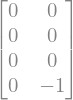

In [18]:
H_x_p['ρ']

In [19]:
if print_level > 2 and max_order >= 2:
    print("\033[96mDifferentiating hessian with respect to parameters\n\033[0m")
Psi_p = None if max_order < 2 else differentiate_to_dict(Psi, p)

In [20]:
Psi_p['β']

⎡⎡  ⎛    α - 1    zₚ        ⎞                 α - 2            zₚ            α
⎢⎢2⋅⎝- kₚ     ⋅α⋅ℯ   + δ - 1⎠               kₚ     ⋅α⋅(α - 1)⋅ℯ            kₚ 
⎢⎢───────────────────────────  0  0  0      ─────────────────────          ───
⎢⎢              3                                      2                      
⎢⎢            cₚ                                     cₚ                       
⎢⎢                                                                            
⎢⎢             0               0  0  0                0                       
⎢⎢                                                                            
⎢⎢             0               0  0  0                0                       
⎢⎢                                                                            
⎢⎢             0               0  0  0                0                       
⎢⎢                                                                            
⎢⎢     α - 2            zₚ                α - 3     

In [21]:
if print_level > 0:
    print("\033[96mSubstituting and simplifying\n\033[0m")

H = substitute_and_simplify(H, all_to_markov, do_simplify)
H_yp = substitute_and_simplify(H_yp, all_to_var, do_simplify)
H_xp = substitute_and_simplify(H_xp, all_to_var, do_simplify)
H_x = substitute_and_simplify(H_x, all_to_var, do_simplify)
H_y = substitute_and_simplify(H_y, all_to_var, do_simplify)
Psi = substitute_and_simplify(Psi, all_to_var, do_simplify)

Substituting and simplifying



In [22]:
Psi

⎡⎡    ⎛   α - 1    z        ⎞                  α - 2              z           
⎢⎢2⋅β⋅⎝- k     ⋅α⋅ℯ  + δ - 1⎠                 k     ⋅α⋅β⋅(α - 1)⋅ℯ            
⎢⎢───────────────────────────  0  0   0       ─────────────────────           
⎢⎢              3                                        2                    
⎢⎢             c                                        c                     
⎢⎢                                                                            
⎢⎢             0               0  0   0                 0                     
⎢⎢                                                                            
⎢⎢                                2                                           
⎢⎢             0               0  ──  0                 0                     
⎢⎢                                 3                                          
⎢⎢                                c                                           
⎢⎢                                                  

In [23]:
if print_level > 2:
    print("\033[96mSubstituting and simplifying parameter derivatives\n\033[0m")

H_p = substitute_and_simplify(H_p, all_to_var, simplify_p)
Γ_p = substitute_and_simplify(Γ_p, all_to_var, simplify_p)
Ω_p = substitute_and_simplify(Ω_p, all_to_var, simplify_p)
y_bar_p = substitute_and_simplify(y_bar_p, all_to_var, simplify_p)
x_bar_p = substitute_and_simplify(x_bar_p, all_to_var, simplify_p)
H_yp_p = substitute_and_simplify(H_yp_p, all_to_var, simplify_p)
H_xp_p = substitute_and_simplify(H_xp_p, all_to_var, simplify_p)
H_y_p = substitute_and_simplify(H_y_p, all_to_var, simplify_p)
H_x_p = substitute_and_simplify(H_x_p, all_to_var, simplify_p)

In [24]:
H_p['α']

⎡  α - 1                   z ⎤
⎢-k     ⋅β⋅(α⋅log(k) + 1)⋅ℯ  ⎥
⎢────────────────────────────⎥
⎢             c              ⎥
⎢                            ⎥
⎢             0              ⎥
⎢                            ⎥
⎢         α  z               ⎥
⎢       -k ⋅ℯ ⋅log(k)        ⎥
⎢                            ⎥
⎣             0              ⎦

In [25]:
    # Substitute and simplify second order derivatives
    if print_level > 1 and max_order >= 2:
        print("\033[96mSubstituting and simplifying 2nd order\033[0m")
    Psi_yp = substitute_and_simplify(Psi_yp, all_to_var, do_simplify)
    Psi_y = substitute_and_simplify(Psi_y, all_to_var, do_simplify)
    Psi_xp = substitute_and_simplify(Psi_xp, all_to_var, do_simplify)
    Psi_x = substitute_and_simplify(Psi_x, all_to_var, do_simplify)

In [26]:
Psi_x[1][2]

⎡0  0  0  0  0  0           0                0      ⎤
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢                   α - 2            z    α - 1    z⎥
⎢0  0  0  0  0  0  k     ⋅α⋅(1 - α)⋅ℯ   -k     ⋅α⋅ℯ ⎥
⎢                                                   ⎥
⎢                       α - 1    z           α  z   ⎥
⎣0  0  0  0  0  0     -k     ⋅α⋅ℯ          -k ⋅ℯ    ⎦

In [27]:
    if print_level > 2 and max_order >= 2:
        print("\033[96mSubstituting and simplifying 2nd order parameter derivatives\n\033[0m")
    Psi_p = substitute_and_simplify(Psi_p, all_to_var, simplify_p)

In [28]:
Psi_p['α'][0]

⎡         α - 1                   z                                      α - 2
⎢     -2⋅k     ⋅β⋅(α⋅log(k) + 1)⋅ℯ                                      k     
⎢     ──────────────────────────────       0  0  0                      ──────
⎢                    3                                                        
⎢                   c                                                         
⎢                                                                             
⎢                   0                      0  0  0                            
⎢                                                                             
⎢                   0                      0  0  0                            
⎢                                                                             
⎢                   0                      0  0  0                            
⎢                                                                             
⎢ α - 2                                 z           

In [29]:
Psi_x

⎡⎡                                                    ⎡0  0  0  0  0  0       
⎢⎢⎡0  0  0  0  0  0  0  0⎤  ⎡0  0  0  0  0  0  0  0⎤  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥, ⎢                      ⎥, ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥

In [30]:
    def build_named_functions(expr, name, *args):
        if expr is None:
            return None
        if isinstance(expr, dict):
            return {key: build_named_functions(value, name + key, *args)
                    for key, value in expr.items()}
        else:
            # create the function from the expression
            f = lambdify(args, expr, modules=["numpy", "scipy", "tensorflow"])
            # rename the function
            source_code = inspect.getsource(f)
            source_code = source_code.replace("_lambdifygenerated", name)
        return source_code

In [31]:
Γ

[σ]

In [32]:
f = lambdify(p, Γ, modules=["numpy", "scipy", "tensorflow"])
source_code = inspect.getsource(f)
source_code = source_code.replace("_lambdifygenerated", "Γ")
source_code

'def Γ(α, β, ρ, δ, σ, Ω_1):\n    return array([[σ]])\n'

In [35]:
f = build_named_functions(Γ, "Γ", *p)

In [36]:
f

'def Γ(α, β, ρ, δ, σ, Ω_1):\n    return array([[σ]])\n'